<a href="https://colab.research.google.com/github/yugamjayant/sept_2023_jh/blob/main/Tweet_Emotion_Recognition(Yugam)_Learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow (And comparision with other pretrained models)

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

---



##Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.model_selection import train_test_split


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.13.0


##Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [2]:
import pandas as pd
import os

# Gave access to google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive
%cd Colab_Notebooks

dataset = pd.read_pickle('merged_training.pkl')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/Colab_Notebooks


In [3]:
tweets = dataset['text'].to_list()
labels = dataset['emotions'].to_list()

Split the dataset into test, train and validation

In [4]:

train_x, test_cv_x, train_y, test_cv_y= train_test_split(tweets, labels, random_state=104,test_size=0.2, shuffle=True)
test_x, cv_x, test_y, cv_y= train_test_split(test_cv_x, test_cv_y, random_state=104,test_size=0.5, shuffle=True)

In [5]:
#Checking the sizes of created
print(f'Len train set: {len(train_x)}, cv set: {len(cv_x)}, len test set: {len(test_x)}')
print(f'Len train set: {len(train_y)}, cv set: {len(cv_y)}, len test set: {len(test_y)}')

Len train set: 333447, cv set: 41681, len test set: 41681
Len train set: 333447, cv set: 41681, len test set: 41681


##Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

##Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

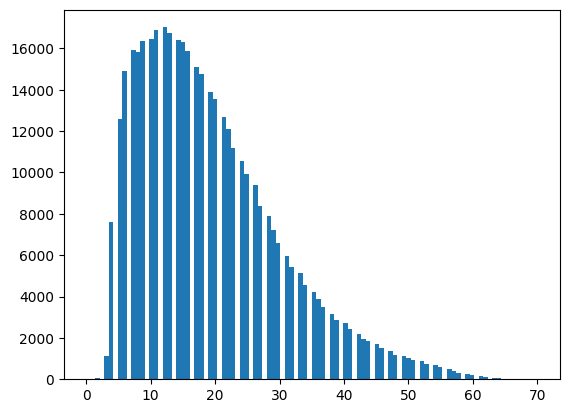

In [ ]:
tweet_lengths = [len(i.split(' ')) for i in tweets]

plt.hist(tweet_lengths, bins = 100, range= (0, 70))
plt.show()

In [ ]:
#In the next step we have to make our input homogeneous, i.e the I/p for all tweets should be of the same length

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_padded_sequeces(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  #Truncting all tweets from the end if I/p sequence is long and padding if its short, setting a limit on length 60
  padded_seq = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = 60)

  return padded_seq

In [ ]:
train_x_seq = get_padded_sequeces(tokenizer, train_x)

In [ ]:
len(np.unique(train_x_seq))

10000

##Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
# First lets check how many classed we have and its distribution

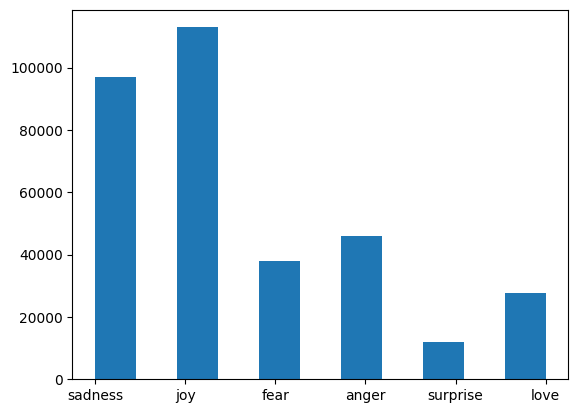

In [ ]:
plt.hist(train_y, bins = 11)
plt.show()

In [5]:
classes = set(train_y)

class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((i, c) for i, c in enumerate(classes))

In [6]:
class_to_index_func = lambda labels: np.array([class_to_index.get(i) for i in labels])

train_y_index = class_to_index_func(train_y)

##Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length = 60),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation = 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)


# '''
# Explainination for using above NN architecture,
# Embedding layer
# - the Embedding layer is an essential component in NLP tasks, as it helps convert raw text data into a format that deep learning models can effectively learn from. It captures semantic relationships between words and provides a foundation for downstream layers in the neural network to make sense of textual data.
# 10000, is vocalbulary size,
# 16: it represents the output dimension or embedding dimension. It specifies the size of the dense vectors that will represent each word in the vocabulary,
# 60: Max I/P seq length

# Bidirectional layer
# capture contextual information from both directions (forward and backward) in the input sequence and retain sequence information.
# 2 bidirectional layer o/p's single bite sized num, rather than an sequnce

# Dense layer
# final Dense layer is responsible for the classification task, where it takes the contextual information learned by the previous layers and produces probability scores for each class
# '''

"\nExplainination for using above NN architecture, \nEmbedding layer\n- the Embedding layer is an essential component in NLP tasks, as it helps convert raw text data into a format that deep learning models can effectively learn from. It captures semantic relationships between words and provides a foundation for downstream layers in the neural network to make sense of textual data.\n10000, is vocalbulary size, \n16: it represents the output dimension or embedding dimension. It specifies the size of the dense vectors that will represent each word in the vocabulary, \n60: Max I/P seq length\n\nBidirectional layer\ncapture contextual information from both directions (forward and backward) in the input sequence and retain sequence information.\n2 bidirectional layer o/p's single bite sized num, rather than an sequnce\n\nDense layer\nfinal Dense layer is responsible for the classification task, where it takes the contextual information learned by the previous layers and produces probability 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 60, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
#Preparing the validation dataset
cv_x_seq = get_padded_sequeces(tokenizer, cv_x)
cv_y_index = class_to_index_func(cv_y)


In [ ]:
h = model.fit(
   train_x_seq, train_y_index,
   validation_data = (cv_x_seq, cv_y_index),
   epochs = 20,
   callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)
   ]
)

Epoch 1/20
10421/10421 [==============================] - 934s 89ms/step - loss: 0.2787 - accuracy: 0.8881 - val_loss: 0.1088 - val_accuracy: 0.9362
Epoch 2/20
10421/10421 [==============================] - 908s 87ms/step - loss: 0.1010 - accuracy: 0.9384 - val_loss: 0.0975 - val_accuracy: 0.9395
Epoch 3/20
10421/10421 [==============================] - 888s 85ms/step - loss: 0.0925 - accuracy: 0.9400 - val_loss: 0.0934 - val_accuracy: 0.9386
Epoch 4/20
10421/10421 [==============================] - 888s 85ms/step - loss: 0.0888 - accuracy: 0.9422 - val_loss: 0.0916 - val_accuracy: 0.9396
Epoch 5/20
10421/10421 [==============================] - 894s 86ms/step - loss: 0.0866 - accuracy: 0.9425 - val_loss: 0.0913 - val_accuracy: 0.9386
Epoch 6/20
10421/10421 [==============================] - 896s 86ms/step - loss: 0.0850 - accuracy: 0.9423 - val_loss: 0.0942 - val_accuracy: 0.9381


##Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

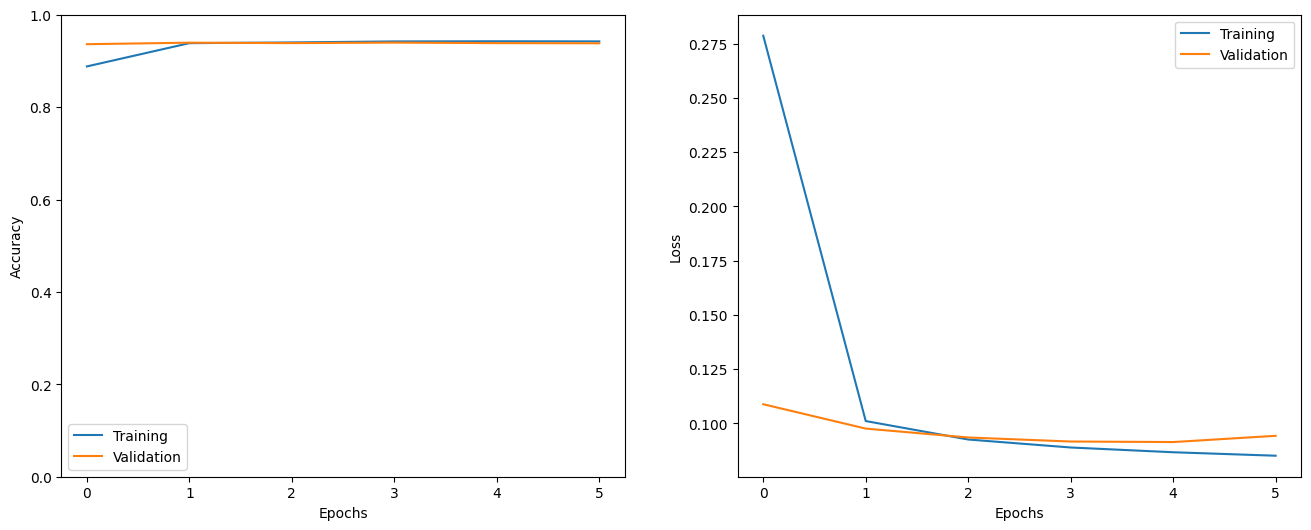

In [ ]:
show_history(h)

In [ ]:
#Preparing the test dataset
test_x_seq = get_padded_sequeces(tokenizer, test_x)
test_y_index = class_to_index_func(test_y)

In [ ]:
_ = model.evaluate(test_x_seq, test_y_index)

1303/1303 [==============================] - 23s 18ms/step - loss: 0.0936 - accuracy: 0.9390


In [ ]:
# Comparing model's output with test set's corrct label

i = random.randint(0, len(test_y)-1)

print('Test tweet: ', test_x[i])
print('Correct emotion: ',test_y[
  i])

p = model.predict(np.expand_dims(test_x_seq[i], axis = 0))[0]
pred_class_label = np.argmax(p).astype(int)

print("Model predicts: ",index_to_class.get(pred_class_label))

Test tweet:  i feel content marketing is valuable from an engagement perspective
Correct emotion:  joy
1/1 [==============================] - 0s 33ms/step
Model predicts:  joy


In [ ]:
# Making a heat map for confusion matrix

test_set_predictions = model.predict(test_x_seq)

test_set_predictions_1 = np.argmax(test_set_predictions, axis = -1)

show_confusion_matrix(test_y_index, test_set_predictions_1, list(classes))

1303/1303 [==============================] - 26s 20ms/step


After bulding this model, I was curious to find out how a pre-trained model would do on this classification task, thus in the following part of this notebook I have tried to finetune a pre-trained model, on my training set to compare the results.

##Roberta multiclass classification model (finetuned)

https://huggingface.co/SamLowe/roberta-base-go_emotions


Pre-process the data

In [22]:
!pip install transformers torch

ERROR: Operation cancelled by user


In [7]:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Same as before
checkpoint = "SamLowe/roberta-base-go_emotions"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = train_x


# Define batch size
batch_size = 32

# Calculate the number of batches
num_batches = len(sequences) // batch_size

# Reshape your data into batches
sequence_batches = np.array_split(sequences, num_batches)
label_index_batches = np.array_split(train_y_index, num_batches)

tokenised_data = []

for sequence_batch in sequence_batches:
  tokenised_batch = dict(tokenizer(list(sequence_batch), padding='max_length', truncation=True, return_tensors="tf", max_length=60))
  tokenised_data.append(tokenised_batch)
# # This is new
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
# labels = tf.convert_to_tensor(train_y_index)
# model.train_on_batch(batch, labels)



In [8]:
tokenizer.save_pretrained("roberta_tokenizer")

('roberta_tokenizer/tokenizer_config.json',
 'roberta_tokenizer/special_tokens_map.json',
 'roberta_tokenizer/vocab.json',
 'roberta_tokenizer/merges.txt',
 'roberta_tokenizer/added_tokens.json',
 'roberta_tokenizer/tokenizer.json')

In [9]:
#batch = np.concatenate(tokenised_data, axis=0)
# batch = tokenised_data[0]
# train_y_index_batch = label_index_batches[0]

# Extract 'input_ids' and 'attention_mask' from each dictionary
input_ids_list = [batch['input_ids'] for batch in tokenised_data]
attention_mask_list = [batch['attention_mask'] for batch in tokenised_data]

# Concatenate 'input_ids' and 'attention_mask' along the batch dimension (axis=0)
no_of_batch_to_conca = 2
concatenated_input_ids = tf.concat(input_ids_list[:no_of_batch_to_conca], axis=0)
concatenated_attention_mask = tf.concat(attention_mask_list[:no_of_batch_to_conca], axis=0)
concatenated_train_y = tf.concat(label_index_batches[:no_of_batch_to_conca], axis=0)

Model Training

In [10]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
import torch
import torch.nn as nn

# Load the pre-trained model and tokenizer
model_name = "SamLowe/roberta-base-go_emotions"  # You can specify the model you want to use
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels = 6, ignore_mismatched_sizes=True)

# Prepare your training data (tokenization, padding, etc.)

# Convert data to PyTorch tensors
input_ids = torch.tensor(concatenated_input_ids.numpy())
attention_mask = torch.tensor(concatenated_attention_mask.numpy())
labels = torch.tensor(concatenated_train_y.numpy())

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)

# Loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 3  # Specify the number of training epochs

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

    # Calculate loss using CrossEntropyLoss
    loss = criterion(logits, labels)

    # Backpropagation
    loss.backward()
    optimizer.step()
    # Optionally, update the learning rate scheduler

# Save or use the fine-tuned model for inference


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
model.save_pretrained("finetuned_roberta")

Model evaluation

In [12]:
#Preparing the test dataset
test_x_seq = dict(tokenizer(test_x[:100], padding='max_length', truncation=True, return_tensors="tf", max_length=60))
test_y_index = class_to_index_func(test_y[:100])

In [13]:
inputs = torch.tensor(test_x_seq["input_ids"].numpy())
attention_mask = torch.tensor(test_x_seq["attention_mask"].numpy())
labels = torch.tensor(test_y_index)

# Forward pass
with torch.no_grad():
    outputs = model(inputs, attention_mask=attention_mask)

# Get predicted labels
predicted_labels = torch.argmax(outputs.logits, dim=1)

# Update correct_predictions and total_examples
correct_predictions = (predicted_labels == labels).sum().item()
total_examples = len(labels)

In [14]:
# Calculate accuracy
accuracy = correct_predictions / total_examples

# Print the accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 31.00%


I achived just 31% accuracy with this model, which is obviously not good enough, there could be many possible reasons for this

- I choose the wrong model
- Limit compute power, I had (I could fine tune the model on just 64 training examples, any larger my noteook was crashing)
- I didn't do it right, etc

Going forward I will further explore on these reasons to improve

# Comparision with twitter-roberta-base-emotion-multilabel-latest

https://huggingface.co/cardiffnlp/twitter-roberta-base-emotion-multilabel-latest

This model had 11 classes, with all 6/11 overlapping with my model, hence I choose to compare this result with this model, without any finetuning I have used this model as it is.

Nverthless, I am working on finetuning this model, to find how does it compares to my NN based model

In [35]:
from transformers import pipeline

pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-emotion-multilabel-latest" )

In [59]:
#Lets not try to predict on whole of test set, lets just do a subset of it
test_x_subset = test_x[:1000]
test_y_subset = test_y[:1000]

# Define batch size
batch_size = 300

# Calculate the number of batches
num_batches = len(test_x_subset) // batch_size

# Reshape your data into batches
test_x_batches = np.array_split(test_x_subset, num_batches)


cardiff_roberta_test_pred_batch_result = []
counter = 0
for test_x_batch in test_x_batches:
  print("Processing batch no: ", counter)
  cardiff_roberta_test_pred = pipe(list(test_x_batch))
  cardiff_roberta_test_pred_batch_result.append(cardiff_roberta_test_pred)
  counter+=1

Processing batch no:  0
Processing batch no:  1
Processing batch no:  2


In [64]:
test_y_pred_int = [[x['label'] for x in batch] for batch in cardiff_roberta_test_pred_batch_result]

test_y_pred = []
for temp_list in test_y_pred_int:
  test_y_pred.extend(temp_list)

In [72]:
len(test_y_pred)

1000

In [74]:
result_comp = [test_y_subset[i] == test_y_pred[i] for i in range(1000)]

In [82]:
pd.Series(result_comp).value_counts()

True     505
False    495
dtype: int64

In [83]:
505/1000

0.505

I Achieved a 50% accuracy on a sample test set, on the other hand, I had achieved 93 on my first NN based model, so this model didn't gave much promising results